# Make Linear Regression Data

This notebook creates slightly noisy data that is amenable to being fit by a linear regression model.
The data arrives in a $100\times 2$ matrix $X$ along with a size-100 vector $y.$ The
data approximately fits the equation

$$y \approx Xw + b,$$

where $w,b\in\mathbb R^2.$

## Imports

In [1]:
# Imports

# TODO(tyler): Remove unused stuff.

%matplotlib inline

import math
import pickle

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d               import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from sklearn.linear_model               import LogisticRegression
from sklearn.model_selection            import train_test_split

## Parameters

In [2]:
n_pts = 100
x_dim = 2

## Create the data

In [3]:
# Choose a fixed random seed for numpy to keep
# things reproducible.

np.random.seed(12)

In [4]:
# Create some random x values with a tad of creativity.
# We could just sample x uniformly or normally, but it's
# more fun (and potentially more bug-revealing) to choose
# them in a more interesting fashion.

X, _ = make_blobs(n_samples=n_pts, n_features=x_dim, centers=3)
X.shape

(100, 2)

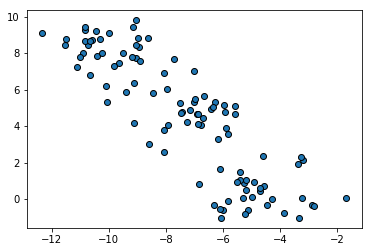

In [5]:
# Let's see what the first two coordinates look like.

plt.scatter(X[:, 0], X[:, 1], edgecolors='k')
plt.show()

In [6]:
# Choose w and b.

w = np.random.rand(x_dim, 1) * 5
b = np.random.rand(1) * 5

print('w:\n', w)
print('b:\n', b)

w:
 [[3.50714654]
 [4.52541479]]
b:
 [1.17899335]


In [7]:
# Set y = X * w + b + eps, where eps is some zero-centered noise.

y = X.dot(w) + b + np.random.randn(n_pts, 1)
y.shape

(100, 1)

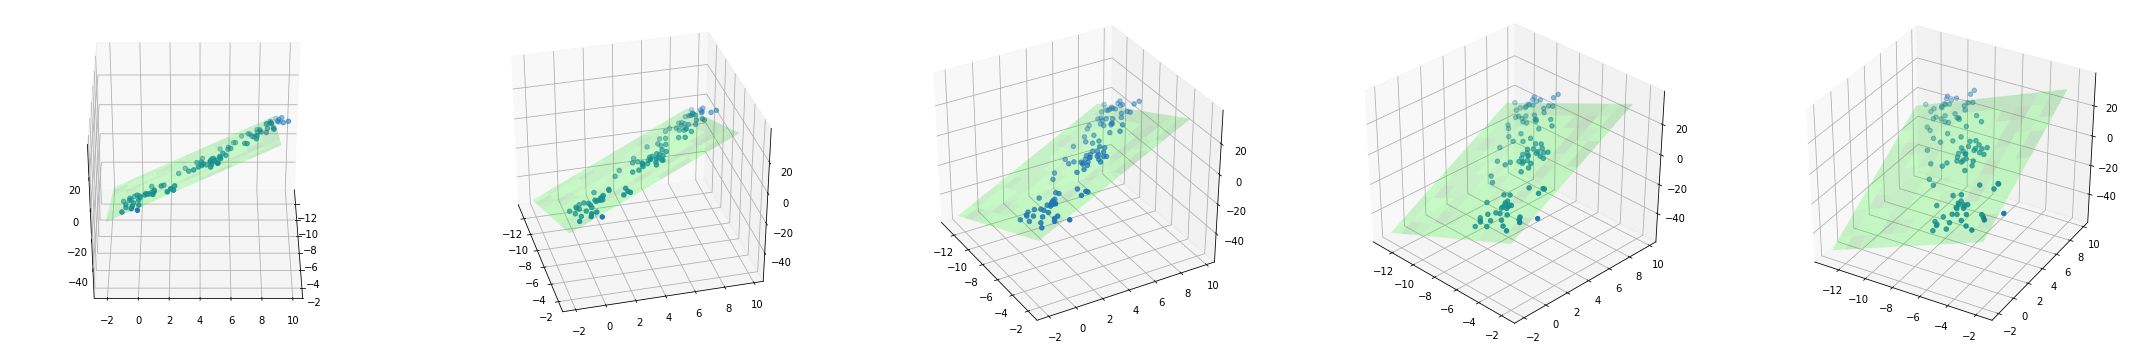

In [9]:
# Perform a visual check of the data.

def low(arr):
    return math.floor(np.min(arr))

def hi(arr):
    return math.ceil(np.max(arr))

def draw_pts(ax):
    xvals, yvals = X[:, 0], X[:, 1]
    x_rng = np.arange(low(xvals), hi(xvals))
    y_rng = np.arange(low(yvals), hi(yvals))
    xx, yy = np.meshgrid(x_rng, y_rng)
    zz = xx * w[0, 0] + yy * w[1, 0] + b
    ax.plot_surface(xx, yy, zz, color=(0, 1, 0, 0.2))
    ax.scatter(xvals, yvals, y)

fig = plt.figure(figsize=(38, 6))

n_figs = 5
for i in range(n_figs):
    ax = fig.add_subplot(1, n_figs, i + 1, projection='3d')
    draw_pts(ax)
    ax.view_init(35, -15 * i)

plt.show()

## Check which parameters we might learn from the data

In [10]:
# TODO Fit the data both with and without regularization.